<a href="https://colab.research.google.com/github/pankajti/qtw/blob/master/Risk_GWP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install eia

  Preparing metadata (setup.py) ... done
  Created wheel for ratelimit: filename=ratelimit-2.2.1-py3-none-any.whl size=5894 sha256=1a478a2e2ce0de78c7bb183e5d2ce4b1712dcedcecb4f914246460cde6b63658
  Stored in directory: /root/.cache/pip/wheels/27/5f/ba/e972a56dcbf5de9f2b7d2b2a710113970bd173c4dcd3d2c902
Successfully built ratelimit


In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import requests
import eia

# Step 3

## Macroeconomic Data


In [ ]:
api_url = "https://api.eia.gov/v2/crude-oil-imports/data/?frequency=monthly&data[0]=quantity&facets[originType][]=WORLD&facets[destinationType][]=US&facets[destinationId][]=US&facets[gradeId][]=MED&facets[originId][]=WORLD&start=2018-01&end=2023-10&sort[0][column]=period&sort[0][direction]=asc&offset=0&length=5000"

# Replace 'your_api_key' with your actual EIA API key
api_key = 'eUHpyXZoiSdhtoFkoVXZa3xhG6YUY2w1fJxpVUlI'
api_url_with_key = f"{api_url}&api_key={api_key}"
response = requests.get(api_url_with_key)

# Check if the response was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()

    # Assuming the relevant data is in a list under 'response' -> 'data'
    # You will need to adjust the keys based on the actual structure of the response
    data_list = data.get('response', {}).get('data', [])

    # Create a DataFrame from the data
    df = pd.DataFrame(data_list)

    # Show the first few rows of the DataFrame
    print(df.head())
else:
    print(f"Error fetching data: {response.status_code}")

    period originId originName originType originTypeName destinationId  \
0  2018-01    WORLD      World      WORLD          World            US   
1  2018-02    WORLD      World      WORLD          World            US   
2  2018-03    WORLD      World      WORLD          World            US   
3  2018-04    WORLD      World      WORLD          World            US   
4  2018-05    WORLD      World      WORLD          World            US   

  destinationName destinationType destinationTypeName gradeId gradeName  \
0   United States              US       United States     MED    Medium   
1   United States              US       United States     MED    Medium   
2   United States              US       United States     MED    Medium   
3   United States              US       United States     MED    Medium   
4   United States              US       United States     MED    Medium   

   quantity    quantity-units  
0     72936  thousand barrels  
1     54097  thousand barrels  
2     68

In [ ]:
print(df.describe())

           quantity
count     70.000000
mean   56512.957143
std     9103.485627
min    37769.000000
25%    50333.250000
50%    55727.000000
75%    61437.750000
max    79358.000000


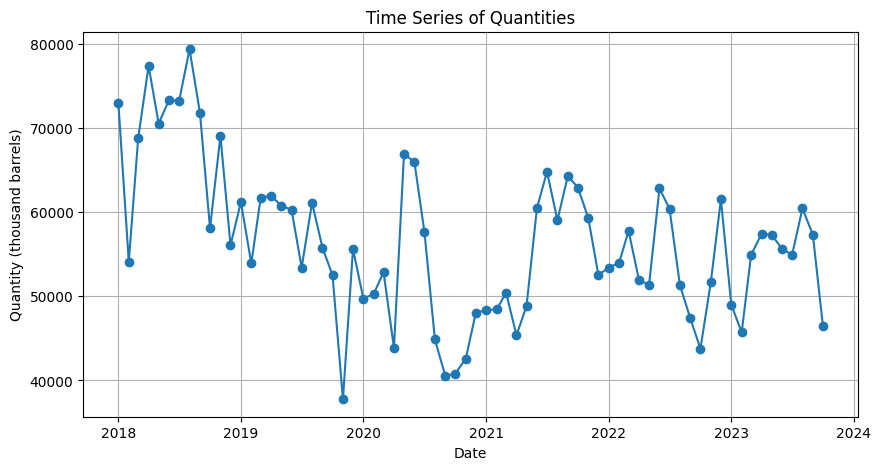

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'period' to datetime
df['period'] = pd.to_datetime(df['period'])

# Ensure the data is sorted by date
df.sort_values('period', inplace=True)

# Plot the time series data
plt.figure(figsize=(10, 5))
plt.plot(df['period'], df['quantity'], marker='o')
plt.title('Time Series of Quantities')
plt.xlabel('Date')
plt.ylabel('Quantity (thousand barrels)')
plt.grid(True)
plt.show()

## Microeconomics Data

In [ ]:
prod_api_url = "https://api.eia.gov/v2/petroleum/crd/crpdn/data/?frequency=monthly&data[0]=value&start=2018-01&end=2023-10&sort[0][column]=period&sort[0][direction]=asc&offset=0&length=5000"

# Replace 'your_api_key' with your actual EIA API key
api_key = 'eUHpyXZoiSdhtoFkoVXZa3xhG6YUY2w1fJxpVUlI'
api_url_with_key = f"{prod_api_url}&api_key={api_key}"
response = requests.get(api_url_with_key)

# Check if the response was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()

    # Assuming the relevant data is in a list under 'response' -> 'data'
    # You will need to adjust the keys based on the actual structure of the response
    data_list = data.get('response', {}).get('data', [])

    # Create a DataFrame from the data
    df2 = pd.DataFrame(data_list)

    # Show the first few rows of the DataFrame
    print(df2.head())
else:
    print(f"Error fetching data: {response.status_code}")

    period duoarea area-name product product-name process      process-name  \
0  2018-01     R5F        NA    EPC0    Crude Oil     FPF  Field Production   
1  2018-01     R50    PADD 5    EPC0    Crude Oil     FPF  Field Production   
2  2018-01     SAK    USA-AK    EPC0    Crude Oil     FPF  Field Production   
3  2018-01     SLA    USA-LA    EPC0    Crude Oil     FPF  Field Production   
4  2018-01     SIL    USA-IL    EPC0    Crude Oil     FPF  Field Production   

     series                                 series-description  value   units  
0  MCRFP5F1  Federal Offshore PADD 5 Field Production of Cr...    419    MBBL  
1  MCRFPP52  West Coast (PADD 5) Field Production of Crude ...    976  MBBL/D  
2  MCRFPAK2  Alaska Field Production of Crude Oil (Thousand...    508  MBBL/D  
3  MCRFPLA1  Louisiana Field Production of Crude Oil (Thous...   3856    MBBL  
4  MCRFPIL2  Illinois Field Production of Crude Oil (Thousa...     19  MBBL/D  


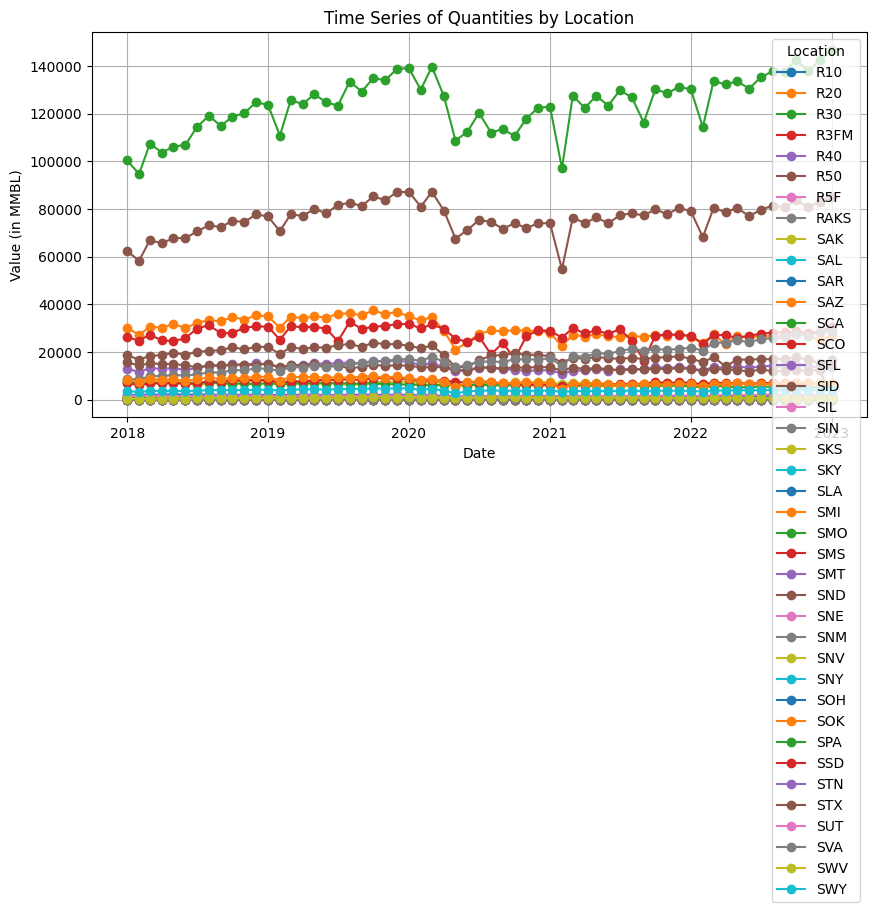

In [ ]:
# Convert 'period' to datetime
df2['period'] = pd.to_datetime(df2['period'])
df2.sort_values('period', inplace=True)
pivot_df = df2.pivot_table(index='period', columns='duoarea', values='value')

# Plot the time series data
plt.figure(figsize=(10, 5))

# Loop through the columns (locations) to plot them
for location in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[location], marker='o', label=location)

# Add title and labels
plt.title('Time Series of Quantities by Location')
plt.xlabel('Date')
plt.ylabel('Value (in MMBL)')

# Add grid and legend
plt.grid(True)
plt.legend(title='Location')

# Show the plot
plt.show()

In [ ]:
stock_data_url = r'https://api.eia.gov/v2/petroleum/stoc/cu/data/?frequency=monthly&data[0]=value&facets[product][]=EPC0&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={}'.format(eia_key)
stock_data= requests.get(stock_data_url)
stock_data_df = pd.DataFrame(stock_data.json()['response']['data'])
stock_data_df.head()

,period,duoarea,area-name,product,product-name,process,process-name,series,series-description,value,units
0,2023-10,R10,PADD 1,EPC0,Crude Oil,STT,Stocks at Tank Farms,MCRSFP11,East Coast (PADD 1) Crude Oil Stocks at Tank F...,2059,MBBL
1,2023-10,R50,PADD 5,EPC0,Crude Oil,STT,Stocks at Tank Farms,MCRSFP51,West Coast (PADD 5) Crude Oil Stocks at Tank F...,23381,MBBL
2,2023-10,R40,PADD 4,EPC0,Crude Oil,STT,Stocks at Tank Farms,MCRSFP41,Rocky Mountain (PADD 4) Crude Oil Stocks at Ta...,21363,MBBL
3,2023-10,R20,PADD 2,EPC0,Crude Oil,STT,Stocks at Tank Farms,MCRSFP21,Midwest (PADD 2) Crude Oil Stocks at Tank Farm...,92477,MBBL
4,2023-10,R30,PADD 3,EPC0,Crude Oil,STT,Stocks at Tank Farms,MCRSFP31,Gulf Coast (PADD 3) Crude Oil Stocks at Tank F...,193850,MBBL


## Financial Data

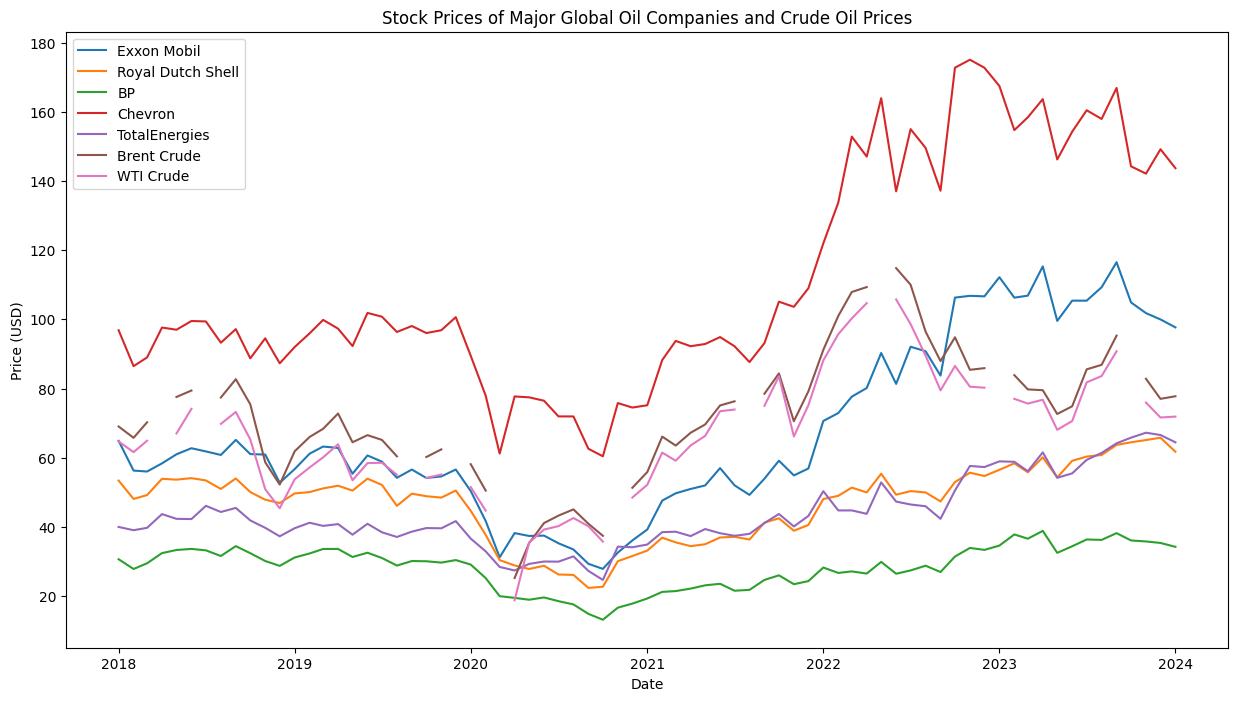

In [ ]:
# Define the ticker symbols for major global oil companies and crude oil
tickers = {
    "Exxon Mobil": "XOM",
    "Royal Dutch Shell": "SHEL",
    "BP": "BP",
    "Chevron": "CVX",
    "TotalEnergies": "TTE",
    "Brent Crude": "BZ=F",
    "WTI Crude": "CL=F"
}

# Fetch historical data for each ticker
data = {}
for name, ticker in tickers.items():
    ticker_data = yf.Ticker(ticker)
    data[name] = ticker_data.history(start="2018-01-01", interval="1mo")['Close']

# Convert to DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(15, 8))
for name in df.columns:
    plt.plot(df.index, df[name], label=name)

plt.title("Stock Prices of Major Global Oil Companies and Crude Oil Prices")
plt.ylabel("Price (USD)")
plt.xlabel("Date")
plt.legend()
plt.show()

# Step 4